<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/satellite_imagery/satellite_imagery_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
%%capture
!pip install rasterio
!pip install fiona

## Donwload Data

In [2]:
# download 4-Band Analytic PlanetScope asset
!curl -O -J https://hello.planet.com/data/s/UG2TX98suVmmi9q/download

# download XML metadata
!curl -O -J https://hello.planet.com/data/s/jqDQE8xUHiD511e/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  148M  100  148M    0     0  25.0M      0  0:00:05  0:00:05 --:--:-- 33.3M
curl: Saved to filename '20190321_174348_0f1a_3B_AnalyticMS.tif'
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10441  100 10441    0     0  19737      0 --:--:-- --:--:-- --:--:-- 19700
curl: Saved to filename '20190321_174348_0f1a_3B_AnalyticMS_metadata.xml'


In [3]:
# download 3-Band Visual PlanetScope asset
!curl -O -J https://hello.planet.com/data/s/ZWwAg1RcmIN5h9R/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.9M  100 65.9M    0     0  22.5M      0  0:00:02  0:00:02 --:--:-- 22.5M
curl: Saved to filename '20160831_180302_0e26_3B_Visual.tif'


## Spatial Data is Special

Unique qualities of satellite imagery require special consideration.

Geospatieal raster imagery:

- Can be multispectral 
- Is spatially referenced 
- Has spatially-relevant metadata

## Defining Resolution in Satellite Imagery

- Spatial resolution: ground area per pixel
- Temporal resolution: frequency between image captures
- Spectral resolution: number of spectral `bands` measures
- Radiometric resolution: bit depth of pixel values

In [4]:
!git clone https://github.com/sarasafavi/remote-sensing-with-python.git

Cloning into 'remote-sensing-with-python'...
remote: Enumerating objects: 166, done.
remote: Total 166 (delta 0), reused 0 (delta 0), pack-reused 166
Receiving objects: 100% (166/166), 10.54 MiB | 34.14 MiB/s, done.
Resolving deltas: 100% (91/91), done.


## Reading satellite data with rasterio

### Loading a dataset

In [5]:
import rasterio

# This notebook explores a single 4 band (blue, green, red, NIR) PlanetScope scene in a UTM projection.
image_file = "20190321_174348_0f1a_3B_AnalyticMS.tif"

satdat = rasterio.open(image_file)
satdat

<open DatasetReader name='20190321_174348_0f1a_3B_AnalyticMS.tif' mode='r'>

In [6]:
# let's look at some basic information about this geoTIFF:

# dataset name
print(satdat.name)

# number of bands in this dataset
print(satdat.count)

20190321_174348_0f1a_3B_AnalyticMS.tif
4


In [7]:
type(satdat)

rasterio.io.DatasetReader

In [8]:
satdat.shape

(4213, 8341)

### Parsing bands

In [9]:
# The dataset reports a band count.
print(satdat.count)

# And provides a sequence of band indexes.  These are one indexing, not zero indexing like Numpy arrays.
print(satdat.indexes)

4
(1, 2, 3, 4)


In [10]:
# PlanetScope 4-band band order: BGRN

blue, green, red, nir = satdat.read()

# Or the slightly less efficient:
#    blue = satdat.read(1)
#    green = satdat.read(2)
#    red = satdat.read(3)
#    nir = satdat.read(4)

# Or read the entire dataset into a single 3D array:
#    data = satdat.read()

In [11]:
# each band is stored as a numpy array, and its values are a numpy data type
print(blue.dtype)

uint16


In [12]:
# using the blue band as an example, examine the width & height of the image (in pixels)

w = blue.shape[0]
h = blue.shape[1]

print("width: {w}, height: {h}".format(w=w, h=h))

width: 4213, height: 8341


### Extracting metadata information from a satellite image

In [13]:
satdat = rasterio.open("20160831_180302_0e26_3B_Visual.tif")

In [14]:
# Minimum bounding box in projected units

print(satdat.bounds)

BoundingBox(left=623577.0, bottom=4199985.0, right=651732.0, top=4214037.0)


In [18]:
# Get dimensions, in map units (using the example GeoTIFF, that's meters)

width_in_projected_units = satdat.bounds.right - satdat.bounds.left
height_in_projected_units = satdat.bounds.top - satdat.bounds.bottom

print(f"Width: {width_in_projected_units:,}, Height: {height_in_projected_units:,}")

Width: 28,155.0, Height: 14,052.0


In [19]:
# Number of rows and columns.

print(f"Rows: {satdat.height:,}, Columns: {satdat.width:,}")

Rows: 4,684, Columns: 9,385


In [20]:
# This dataset's projection uses meters as distance units.  What are the dimensions of a single pixel in meters?

xres = (satdat.bounds.right - satdat.bounds.left) / satdat.width
yres = (satdat.bounds.top - satdat.bounds.bottom) / satdat.height

print(xres, yres)
print("Are the pixels square: {}".format(xres == yres))

3.0 3.0
Are the pixels square: True


In [21]:
# Get coordinate reference system

satdat.crs

CRS.from_epsg(32610)

In [22]:
# Convert pixel coordinates to world coordinates.

# Upper left pixel
row_min = 0
col_min = 0

# Lower right pixel.  Rows and columns are zero indexing.
row_max = satdat.height - 1
col_max = satdat.width - 1

# Transform coordinates with the dataset's affine transformation.
topleft = satdat.transform * (row_min, col_min)
botright = satdat.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (623577.0, 4214037.0)
Bottom right corner coordinates: (637626.0, 4185885.0)


In [23]:
# All of the metadata required to create an image of the same dimensions, datatype, format, etc. is stored in
# the dataset's profile:

satdat.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9385, 'height': 4684, 'count': 4, 'crs': CRS.from_epsg(32610), 'transform': Affine(3.0, 0.0, 623577.0,
       0.0, -3.0, 4214037.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

### File Compression
Raster datasets use compression to reduce filesize. There are a number of compression methods, all of which fall into two categories: lossy and lossless. Lossless compression methods retain the original values in each pixel of the raster, while lossy methods result in some values being removed. Because of this, lossy compression is generally not well-suited for analytic purposes, but can be very useful for reducing storage size of visual imagery.

All Planet data products are available as GeoTIFFs using lossless LZW compression. By creating a lossy-compressed copy of a visual asset, we can significantly reduce the dataset's filesize. In this example, we will create a copy using the "JPEG" lossy compression method:

In [24]:
import os
from humanize import naturalsize as sz

# returns size in bytes
size = os.path.getsize("20160831_180302_0e26_3B_Visual.tif")

# output a human-friendly size
print(sz(size))

69.1 MB


Copying a dataset

In [27]:
# read all bands from source dataset into a single 3-dimensional ndarray

data = satdat.read()

In [28]:
# write new file using profile metadata from original dataset
# and specifying JPEG compression

profile = satdat.profile
profile['compress'] = 'JPEG'

with rasterio.open('compressed.tif', 'w', **profile) as dst:
    dst.write(data)

In [29]:
new_size = os.path.getsize("compressed.tif")
print(sz(new_size))

13.6 MB


### Clip a satellite image to AOI and reproject into a new CRS

In [30]:
from matplotlib import pyplot as plt

# This notebook explores a single 4 band (blue, green, red, NIR) PlanetScope scene in a UTM projection.
image_file = "20190321_174348_0f1a_3B_AnalyticMS.tif"

# Use Rasterio to open the image.
satdat = rasterio.open(image_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


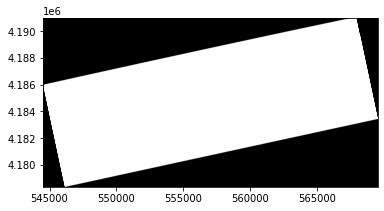

In [32]:
from rasterio.plot import show
show(satdat);


Using a mask to cut raster along boundary
In this exercise we're going to clip a fullsized PlanetScope dataset to an area of interest (AOI) polygon. Because this AOI is a vector dataset (versus raster), we'll use Rasterio's sister-library, Fiona, to read the geoJSON dataset:

masked.pngArea of Interest (shown here in red) displayed over a portion of the complete dataset

In order to clip our original raster to the boundary defined by the AOI, we'll use rasterio's mask function. This will create a copy of our original dataset, with all pixels outside of the input AOI shape set to nodata values.

In [39]:
import fiona

# use fiona to open our AOI GeoJSON
with fiona.open('./remote-sensing-with-python/notebooks/aoi.geojson') as f:
    aoi = [feature["geometry"] for feature in f]

In [40]:
# import rasterio's mask tool
from rasterio.mask import mask

# apply mask with crop=True to crop the resulting raster to the AOI's bounding box
with rasterio.open(image_file) as img:
    clipped, transform = mask(img, aoi, crop=True)
    
print(clipped.shape)

(4, 2308, 3375)


In [41]:
# use the metadata from our original mosaic
meta = img.meta.copy()

# update metadata with new, clipped mosaic's boundaries
meta.update({"transform": transform,
    "height":clipped.shape[1],
    "width":clipped.shape[2]})

# write the clipped-and-cropped dataset to a new GeoTIFF
with rasterio.open('clipped.tif', 'w', **meta) as dst:
    dst.write(clipped)

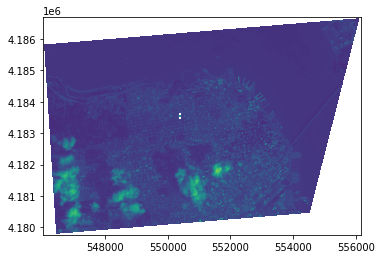

In [43]:
clipped_img = rasterio.open("clipped.tif")
show(clipped_img);

## Reprojecting with rasterio
Now let's reproject our clipped dataset: for this example, we'll reproject into EPSG 4326

In [44]:
from rasterio.warp import calculate_default_transform, reproject

# define our target CRS - rasterio will accept any CRS that can be defined using WKT
target_crs = 'EPSG:4326'


### Transforms
In order to translate pixel coordinates in a raster dataset into coordinates that use a spatial reference system, an affine transformation must be applied to the dataset. This transform is a matrix used to translate rows and columns of pixels into (x,y) spatial coordinate pairs. Every spatially referenced raster dataset has an affine transform that describes its pixel-to-map-coordinate transformation.

In order to reproject a raster dataset from one coordinate reference system to another, rasterio uses the transform of the dataset: this can be calculated automatically using rasterio's calculate_default_transform method

In [45]:
# calculate a transform and new dimensions using our dataset's current CRS and dimensions
transform, width, height = calculate_default_transform(clipped_img.crs, 
                                                      target_crs, 
                                                       clipped_img.width, 
                                                       clipped_img.height, 
                                                       *clipped_img.bounds)

Using a copy of the metadata from the clipped raster dataset and the transform we defined above, we can write a new geoTIFF containing the reprojected and clipped raster data:

In [46]:
# Copy the metadata from the clipped dataset
metadata = clipped_img.meta.copy()

# Change the CRS, transform, and dimensions in metadata to match our desired output dataset
metadata.update({'crs':target_crs, 
                'transform':transform,
                'width':width,
                'height':height})

In [47]:
# apply the transform & metadata to perform the reprojection
# here we're saving the output to a new 'clipped_4326.tif' file
with rasterio.open('clipped_4326.tif', 'w', **metadata) as reprojected:
    for band in range(1, clipped_img.count + 1):
        reproject(
            source=rasterio.band(clipped_img, band),
            destination=rasterio.band(reprojected, band),
            src_transform=clipped_img.transform,
            src_crs=clipped_img.crs,
            dst_transform=transform,
            dst_crs=target_crs
        )

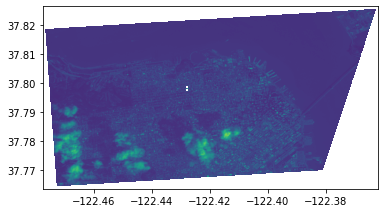

In [49]:
# take a look at our clipped & reprojected dataset
reproj = rasterio.open("clipped_4326.tif")
show(reproj);

## Demonstrate the relationship between Rasterio datasets and NumPy n-dimensional arrays

### Load dataset

In [50]:
satdat = rasterio.open("20190321_174348_0f1a_3B_AnalyticMS.tif")

In [51]:
blue, green, red, nir = satdat.read()

In [53]:
# Bands are stored as Numpy arrays.

type(blue)

numpy.ndarray

In [54]:
# How many dimensions would a single raster band have?  Two dimensions: rows and columns.
blue.ndim

2

In [55]:
blue.dtype

dtype('uint16')

In [56]:
# Output a min & max pixel value in each band.

for band in [blue, green, red, nir]:
    print("min {min} max {max}".format(min=band.min(), max=band.max()))

min 0 max 30256
min 0 max 20671
min 0 max 27564
min 0 max 33932


In [57]:
import math

# Let's grab the pixel 10km east and 10km south of the upper left corner

# World coordinates for the desired pixel.
x_coord = satdat.bounds.left + 10000
y_coord = satdat.bounds.top - 10000

# Convert world coordinates to pixel.  World coordinates may not transform precisely to row and column indexes,
# but a Numpy array can only be indexed by integer values.  The 'op' parameter for 'satdat.index()' determines
# how the transformed values are rounded.  In some cases any point falling within a pixel should be considered
# contained, and in other cases only points falling within one portion of the pixels hould be considered contained.
# The 'op' parameter lets users make this decision on their own.  The values must still be cast to integers.
col, row = satdat.index(x_coord, y_coord, op=math.floor)
col = int(col)
row = int(row)


# Now let's look at the value of each band at this pixel
print("Red: {}".format(red[row, col]))
print("Green: {}".format(green[row, col]))
print("Blue: {}".format(blue[row, col]))
print("NIR: {}".format(nir[row, col]))

Red: 2771
Green: 3974
Blue: 4603
NIR: 1008


## Visualizing Satellite Imagery with matplotlib

In [58]:
from matplotlib import pyplot as plt

# This notebook explores a single 4 band (blue, green, red, NIR) PlanetScope scene in a UTM projection.
# For the sake of efficiency, here we will use the clipped geoTIFF created previously
image_file = "clipped.tif"

# Use Rasterio to open the image.
satdat = rasterio.open(image_file)

In [59]:
# scale values for display purposes
def scale(band):
    return band / 10000.0

# Load the bands into numpy arrays
# recall that we previously learned PlanetScope band order is BGRN
blue = scale(satdat.read(1))
green = scale(satdat.read(2))
red = scale(satdat.read(3))
nir = scale(satdat.read(4))

In [60]:
# Use numpy to create two stacks of bands:
import numpy
rgb = numpy.dstack((red, green, blue))
nrg = numpy.dstack((nir, red, green))

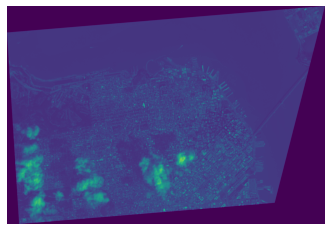

In [62]:
# Use imshow to load the blue band.
fig = plt.imshow(blue)

# Display the results.
plt.axis("off")
plt.show()

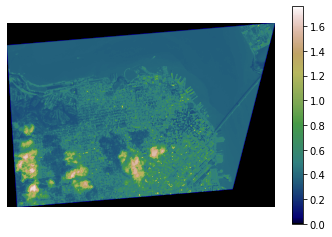

In [63]:
# Plot the green band using a non-default color ramp & a color bar
# see also: https://matplotlib.org/users/colormaps.html
fig = plt.imshow(green)
fig.set_cmap('gist_earth')
plt.colorbar()
plt.axis("off")
# Display the results.
plt.show()

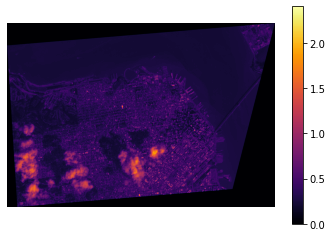

In [64]:

# Plot the red band

fig = plt.imshow(red)
fig.set_cmap('inferno')
plt.colorbar()

# Since the axis labels are useless here, let's turn them off.
plt.axis('off')

# Display the results.
plt.show()

### Displaying Composite Imagery

In [65]:

# Use numpy to create two stacks of bands:
import numpy
rgb = numpy.dstack((red, green, blue))
nrg = numpy.dstack((nir,red,green))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


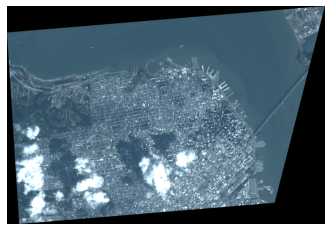

In [68]:

# plot the RGB stack to see a true-color representation
plt.axis("off")
plt.imshow(rgb);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


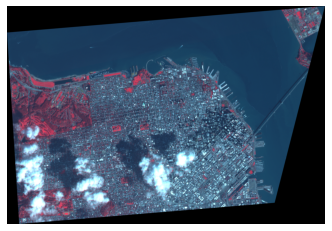

In [70]:
# use the NRG stack to display a false-color composite, highlighting vegetation
# in clipped.tif, the grassy Presidio and Golden Gate Park become easy to spot
plt.axis("off")
plt.imshow(nrg);

## Using matplotlib to plot a histogram of pixel values

In [71]:
import rasterio
import numpy
import math
from matplotlib import pyplot as plt

# This notebook explores a single 4 band (blue, green, red, NIR) PlanetScope scene in a UTM projection.
image_file = "20190321_174348_0f1a_3B_AnalyticMS.tif"

# Use Rasterio to open the image.
satdat = rasterio.open(image_file)

In [72]:
# Load the 4 bands into 2d arrays - recall that we previously learned PlanetScope band order is BGRN.
blue, green, red, nir = satdat.read()

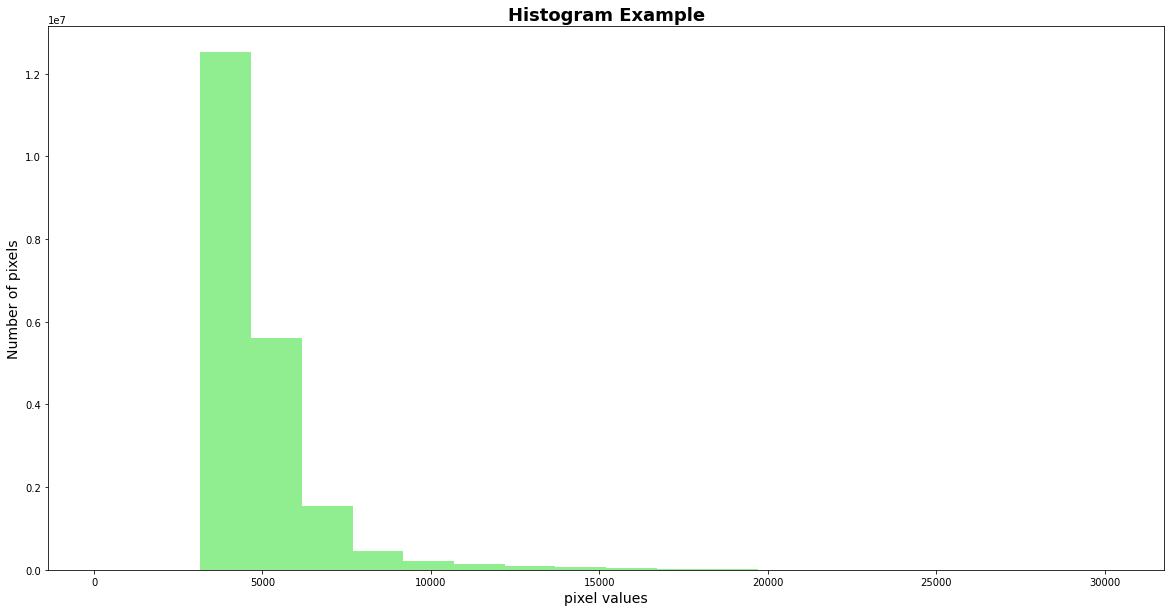

In [73]:
# Define a new figure
fig2 = plt.figure(figsize=(20,10))

# Give this new figure a subplot, which will contain the histogram itself
ax = fig2.add_subplot(111)

# Add a title & (x,y) labels to the plot
plt.title("Histogram Example", fontsize=18, fontweight='bold')
plt.xlabel("pixel values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)

# let's plot non-null blue band values as an example
# For the x-axis, we want to count every pixel that has a value
x = blue[numpy.not_equal(blue, satdat.nodata)]

# Define the number of bins to divide the data into
bins = 20

# Define a color for the histogram
# You can use https://matplotlib.org/2.0.0/examples/color/named_colors.html as a reference
color = 'lightgreen'

# call 'hist` with our x-axis, bins, and color details
ax.hist(x,bins,color=color)

# Save the generated figure to an external image file
fig2.savefig("histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# Finally - let's take a look!
plt.show()